# Imports

In [1]:
import time
notebookstart = time.time()

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import os

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from IPython.display import display

In [5]:
PATH = 'data/nyc-taxi/'

# Load training and test data

The entire dataset has about 55,423,857 rows

In [6]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column)
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime']

In [7]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = 55423857 // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [8]:
%%time
i=0
for df_chunk in pd.read_csv(f'{PATH}train.csv', usecols=cols_train, dtype=types, chunksize=chunksize):
    
    i = i+1
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], format='%Y-%m-%d %H') 
    
    df_list.append(df_chunk) 

DataFrame Chunk 1/6
DataFrame Chunk 2/6
DataFrame Chunk 3/6
DataFrame Chunk 4/6
DataFrame Chunk 5/6
DataFrame Chunk 6/6
CPU times: user 2min 7s, sys: 12.8 s, total: 2min 20s
Wall time: 2min 20s


In [9]:
train_df = pd.concat(df_list)

del df_list

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [11]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [12]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

CPU times: user 1.75 s, sys: 1.52 s, total: 3.27 s
Wall time: 11.2 s


In [13]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')

CPU times: user 663 ms, sys: 697 ms, total: 1.36 s
Wall time: 1.36 s


In [14]:
test_df = pd.read_csv(f'{PATH}test.csv', usecols=cols_test, dtype=types)
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], format='%Y-%m-%d %H') 

In [15]:
test_df.to_feather('tmp/taxi-test-raw')

# Remove missing values

In [16]:
train_df.isnull().sum() 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [17]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [18]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df.dropna(how='any', axis='rows', inplace=True)

new_len = len(train_df)
print(f'New size: {old_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423856
New size: 55423856
376 rows removed


# Longitude and latitude

## Bounding box for test data

The latitude of New York City, NY, USA is **40.730610**, and the longitude is **-73.935242**.

In [19]:
plongmin, plongmax = test_df.pickup_longitude.min(),test_df.pickup_longitude.max()
dlongmin, dlongmax = test_df.dropoff_longitude.min(),test_df.dropoff_longitude.max()
platmin, platmax = test_df.pickup_latitude.min(),test_df.pickup_latitude.max()
dlatmin, dlatmax = test_df.dropoff_latitude.min(),test_df.dropoff_latitude.max()

In [20]:
print(f"pickup longitude min and max:\t {plongmin},  {plongmax}")
print(f"dropoff longitude min and max:\t {dlongmin},  {dlongmax}")
print()
print(f"pickup latitude min and max:\t  {platmin},  {platmax}")
print(f"dropoff longitude min and max:\t  {dlatmin},  {dlatmax}")

pickup longitude min and max:	 -74.25218963623047,  -72.98653411865234
dropoff longitude min and max:	 -74.26324462890625,  -72.990966796875

pickup latitude min and max:	  40.573143005371094,  41.709556579589844
dropoff longitude min and max:	  40.568973541259766,  41.69668197631836


In [21]:
print("Bounding box for pickup")
print(f"({plongmin},{platmin},{plongmax},{platmax})")

Bounding box for pickup
(-74.25218963623047,40.573143005371094,-72.98653411865234,41.709556579589844)


In [22]:
print(f"Bounding box for pickup")
print(f"({dlongmin},{dlatmin},{dlongmax},{dlatmax})")

Bounding box for pickup
(-74.26324462890625,40.568973541259766,-72.990966796875,41.69668197631836)


In [23]:
step = 0.02

longmin_limit = min(plongmin,dlongmin)-step
latmin_limit = min(platmin,dlatmin)-step 
latmax_limit = max(platmax,dlatmax)+step
longmax_limit = max(plongmax, dlongmax)+step

longmin_limit, latmin_limit, longmax_limit, latmax_limit

(-74.28324462890625, 40.54897354125976, -72.96653411865235, 41.72955657958985)

## Exclude training data for those outside bounding box

In [24]:
is_outside_plong = ~train_df.pickup_longitude.between(longmin_limit,longmax_limit)
is_outside_plat = ~train_df.pickup_latitude.between(latmin_limit,latmax_limit)

is_outside_dlong = ~train_df.dropoff_longitude.between(longmin_limit,longmax_limit)
is_outside_dlat = ~train_df.dropoff_latitude.between(latmin_limit,latmax_limit)

is_outside_plong.sum(), is_outside_plat.sum(), is_outside_dlong.sum(), is_outside_dlat.sum()

(1107363, 1102389, 1103750, 1102301)

In [25]:
is_outside_range = is_outside_plong | is_outside_plat | is_outside_dlong | is_outside_dlat
is_outside_range.sum()

1182186

## Comparisons of bounding boxes

Black box is bounding box with step 0.3, blue boxes are pickup and dropoff bounding box

1,170,362 outside range

http://bboxfinder.com/#40.268974,-74.563245,42.009557,-72.686534 



![bbox with 0.3 step limit](./img/bbox-0.3.jpg)

Black box is bounding box with step 0.02, blue boxes are pickup and dropoff bounding box

1,182,186 outside range

http://bboxfinder.com/#40.548974,-74.283245,41.729557,-72.966534

![bbox with 0.02 step limit](./img/bbox-0.02.jpg)

## Remove those outside range

In [26]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[~is_outside_range] # keep those NOT outside range

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423480
New size: 54241294
1,182,186 rows removed


# Passenger Count

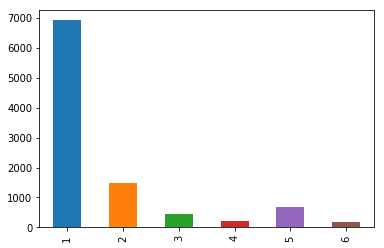

In [27]:
test_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [28]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

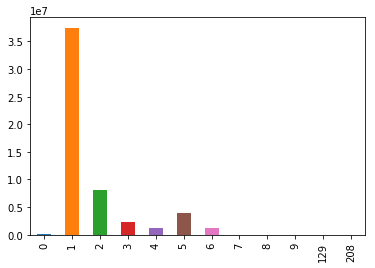

In [29]:
train_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [30]:
train_df.passenger_count.value_counts().sort_index()

0        190840
1      37510194
2       8011643
3       2382491
4       1155380
5       3840527
6       1150154
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [31]:
# number rows with passenger = 0 or more than 6
len(train_df[~(train_df.passenger_count.between(1,6))])

190905

In [32]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.passenger_count.between(1,6))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54241294
New size: 54050389
190,905 rows removed


# Fare Amount

In [33]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.326141)

In [34]:
(train_df.fare_amount.quantile(0.99), train_df.fare_amount.quantile(0.999),
 train_df.fare_amount.quantile(0.9999),train_df.fare_amount.quantile(0.99999),
 train_df.fare_amount.quantile(0.999999))

(52.0, 77.75, 134.0, 225.0, 450.0)

In [35]:
(len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.9999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.999999))]))

(538417, 54028, 5377, 533, 53)

In [36]:
fare_max = 250
fare_min = 2.5

len(train_df[~(train_df.fare_amount.between(fare_min,fare_max))])

4372

In [37]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.fare_amount.between(fare_min,fare_max))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54050389
New size: 54046017
4,372 rows removed


# Checkpoint 1

In [38]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [39]:
%%time
train_df.to_feather('tmp/taxi-train-v8-chkpt1')

CPU times: user 1.6 s, sys: 1.28 s, total: 2.88 s
Wall time: 2.08 s


In [40]:
%%time
test_df.to_feather('tmp/taxi-test-v8-chkpt1')

CPU times: user 6.63 ms, sys: 452 µs, total: 7.08 ms
Wall time: 4.93 ms


In [41]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v8-chkpt1')

CPU times: user 613 ms, sys: 721 ms, total: 1.33 s
Wall time: 1.33 s


In [42]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v8-chkpt1')

CPU times: user 2.61 ms, sys: 460 µs, total: 3.07 ms
Wall time: 2.58 ms


# Date Time

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54046017 entries, 0 to 54046016
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [44]:
def split_datetime(df):
    # Extract date attributes and then drop the pickup_datetime column
    df['year'] = (df['pickup_datetime'].dt.year-2000).astype('uint8')  
    df['month'] = df['pickup_datetime'].dt.month.astype('uint8')  
    df['week'] = df['pickup_datetime'].dt.week.astype('uint8')  
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek.astype('uint8')  
    df['day'] = df['pickup_datetime'].dt.day.astype('uint8')  
    df['hour'] = df['pickup_datetime'].dt.hour.astype('uint8')  
    
    df.drop('pickup_datetime', axis=1, inplace=True)

In [45]:
%%time
split_datetime(train_df)

CPU times: user 20.3 s, sys: 4.29 s, total: 24.6 s
Wall time: 24.3 s


In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54046017 entries, 0 to 54046016
Data columns (total 12 columns):
fare_amount          float32
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 uint8
month                uint8
week                 uint8
dayofweek            uint8
day                  uint8
hour                 uint8
dtypes: float32(5), uint8(7)
memory usage: 1.4 GB


In [47]:
split_datetime(test_df)

# Checkpoint 2

In [48]:
%%time
train_df.to_feather('tmp/taxi-train-v8-chkpt2')

CPU times: user 1.26 s, sys: 992 ms, total: 2.25 s
Wall time: 1.74 s


In [49]:
%%time
test_df.to_feather('tmp/taxi-test-v8-chkpt2')

CPU times: user 9.12 ms, sys: 205 µs, total: 9.33 ms
Wall time: 6.38 ms


In [50]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v8-chkpt2')

CPU times: user 567 ms, sys: 837 ms, total: 1.4 s
Wall time: 1.4 s


In [51]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v8-chkpt2')

CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 2.56 ms


# Add travel vector and distance

In [52]:
def add_travel_vector_features(df):
    df['longitude_distance'] = df.dropoff_longitude - df.pickup_longitude
    df['latitude_distance'] = df.dropoff_latitude - df.pickup_latitude

In [53]:
def add_simple_distance(df):
    df['simple_distance'] = np.abs(df.longitude_distance)  + np.abs(df.latitude_distance)

In [54]:
add_travel_vector_features(train_df)
add_travel_vector_features(test_df)

add_simple_distance(train_df)
add_simple_distance(test_df)

# Checkpoint 3

In [55]:
%%time
train_df.to_feather('tmp/taxi-train-v8-Baseline')

CPU times: user 2.24 s, sys: 1.85 s, total: 4.09 s
Wall time: 3.92 s


In [56]:
%%time
test_df.to_feather('tmp/taxi-test-v8-Baseline')

CPU times: user 8.63 ms, sys: 4.13 ms, total: 12.8 ms
Wall time: 8.64 ms


In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54046017 entries, 0 to 54046016
Data columns (total 15 columns):
fare_amount           float32
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
year                  uint8
month                 uint8
week                  uint8
dayofweek             uint8
day                   uint8
hour                  uint8
longitude_distance    float32
latitude_distance     float32
simple_distance       float32
dtypes: float32(8), uint8(7)
memory usage: 2.0 GB


In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 14 columns):
pickup_longitude      9914 non-null float32
pickup_latitude       9914 non-null float32
dropoff_longitude     9914 non-null float32
dropoff_latitude      9914 non-null float32
passenger_count       9914 non-null uint8
year                  9914 non-null uint8
month                 9914 non-null uint8
week                  9914 non-null uint8
dayofweek             9914 non-null uint8
day                   9914 non-null uint8
hour                  9914 non-null uint8
longitude_distance    9914 non-null float32
latitude_distance     9914 non-null float32
simple_distance       9914 non-null float32
dtypes: float32(7), uint8(7)
memory usage: 338.9 KB


In [59]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 4.31 Minutes
